## FNO: Learning diffusivity (m) to solution (u) map for the Poisson problem

Data is located in `../data` directory, and key data of our interest is in `Poisson_FNO_samples.npz` file.

## On data
The Dropbox folder [NeuralOperator_Survey_Shared_Data_March2025](https://www.dropbox.com/scl/fo/5dg02otewg7j0bt7rhkuf/AOfAAc2SaWOgO-Yg25IlTXs?rlkey=t900geej8y8z327y5f8wu4yc9&st=t9c8qimk&dl=0) contains the key data to reproduce the results in the survey paper. 

If you did not generate data by running `survey_work/problems/poisson/Poisson.ipynb`, consider copying the contents of dropbox folder `NeuralOperator_Survey_Shared_Data_March2025/survey_work/problems/poisson/data/` into `survey_work/problems/poisson/data/` before running this notebook.


### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os

import torch
import numpy as np

src_path = "../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import field_plot_grid
from plot_loss import plot_loss

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessorFNO

sys.path.append(src_path + 'nn/fno/')
from torch_fno2d import FNO2D
import uq

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data_folder = '../../../autodl-tmp/data/'
results_dir = data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [3]:
num_train = 3500
num_test = 1000

num_Y_components = 1 # scalar field
out_coordinate_dimension = 2 # domain for output function is 2D

coarsen_grid_factor = 1 # select every coarsen_grid_factor-th point so that we can coarsen the grid

# training hyperparameters
batch_size = 20
epochs = 500
lr = 1.0e-3

data_prefix = 'Poisson'
data = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_no-ood.npz', num_train, num_test, num_Y_components, coarsen_grid_factor)

train_data = {'X_train': data.X_train, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'Y_train': data.Y_test}

# get data to save
data_to_save = data.get_data_to_save()

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)

X_train: torch.Size([3500, 51, 51, 3])
Y_train: torch.Size([3500, 51, 51, 1])
X_test: torch.Size([1000, 51, 51, 3])
Y_test: torch.Size([1000, 51, 51, 1])


## Create model and train the network

In [4]:
num_layers = 3
width = 20 # dimension of hidden output space
fourier_modes1 = 8
fourier_modes2 = 8

model_save_path = results_dir + 'FNO/'
model_save_file = model_save_path + 'model.pkl'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = FNO2D(num_layers, width, fourier_modes1, fourier_modes2, \
              num_Y_components, save_file = model_save_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Using device: cuda
Number of trainable parameters: 154961


In [5]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_Y_components': num_Y_components, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'coarsen_grid_factor': coarsen_grid_factor, \
                    'num_layers': num_layers, \
                    'width': width, \
                    'fourier_modes1': fourier_modes1, \
                    'fourier_modes2': fourier_modes2, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}

# attach it to the model
model.metadata = model_metadata


In [9]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 154961 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 4.134e-01, Test Loss (l2 squared): 2.270e-01, Time (sec): 1.649
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 6.672e-03, Test Loss (l2 squared): 7.113e-03, Time (sec): 1.481
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 4.735e-03, Test Loss (l2 squared): 4.583e-03, Time (sec): 1.799
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
----

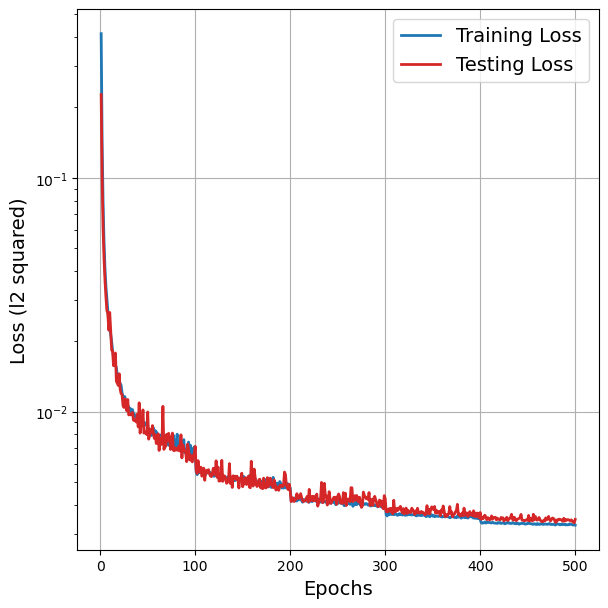

In [10]:
## Plotting the loss history

plot_loss( model.train_loss_log[:, 0], \
           model.test_loss_log[:, 0], \
           fs = 14, lw = 2, \
           savefile = results_dir+'loss_his.png', \
           figsize = [6,6])

## Test and plot the output of network

In [11]:
# load the model
model = torch.load(model_save_file, weights_only=False)

In [ ]:
Y_test = test_data['Y_train'].detach().numpy()
Y_test_pred = model.predict(test_data['X_train']).detach().cpu().numpy()
print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))
a = Y_test.reshape(Y_test.shape[0], -1)
b = Y_test_pred.reshape(Y_test_pred.shape[0], -1)
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))
error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)
print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 51, 51, 1), test_pred shape: (1000, 51, 51, 1)
a shape: (1000, 2601), b shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 6.918e-02, Std Loss (rel l2): 2.186e-02


In [14]:
def apply_grid_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids[:, 0], bc_node_ids[:,1]] = bc_value
    return u

i_plot =   993, error (rel l2): 4.050e-03
i_plot =   859, error (rel l2): 6.794e-03
i_plot =   298, error (rel l2): 4.282e-03
i_plot =   553, error (rel l2): 6.470e-03


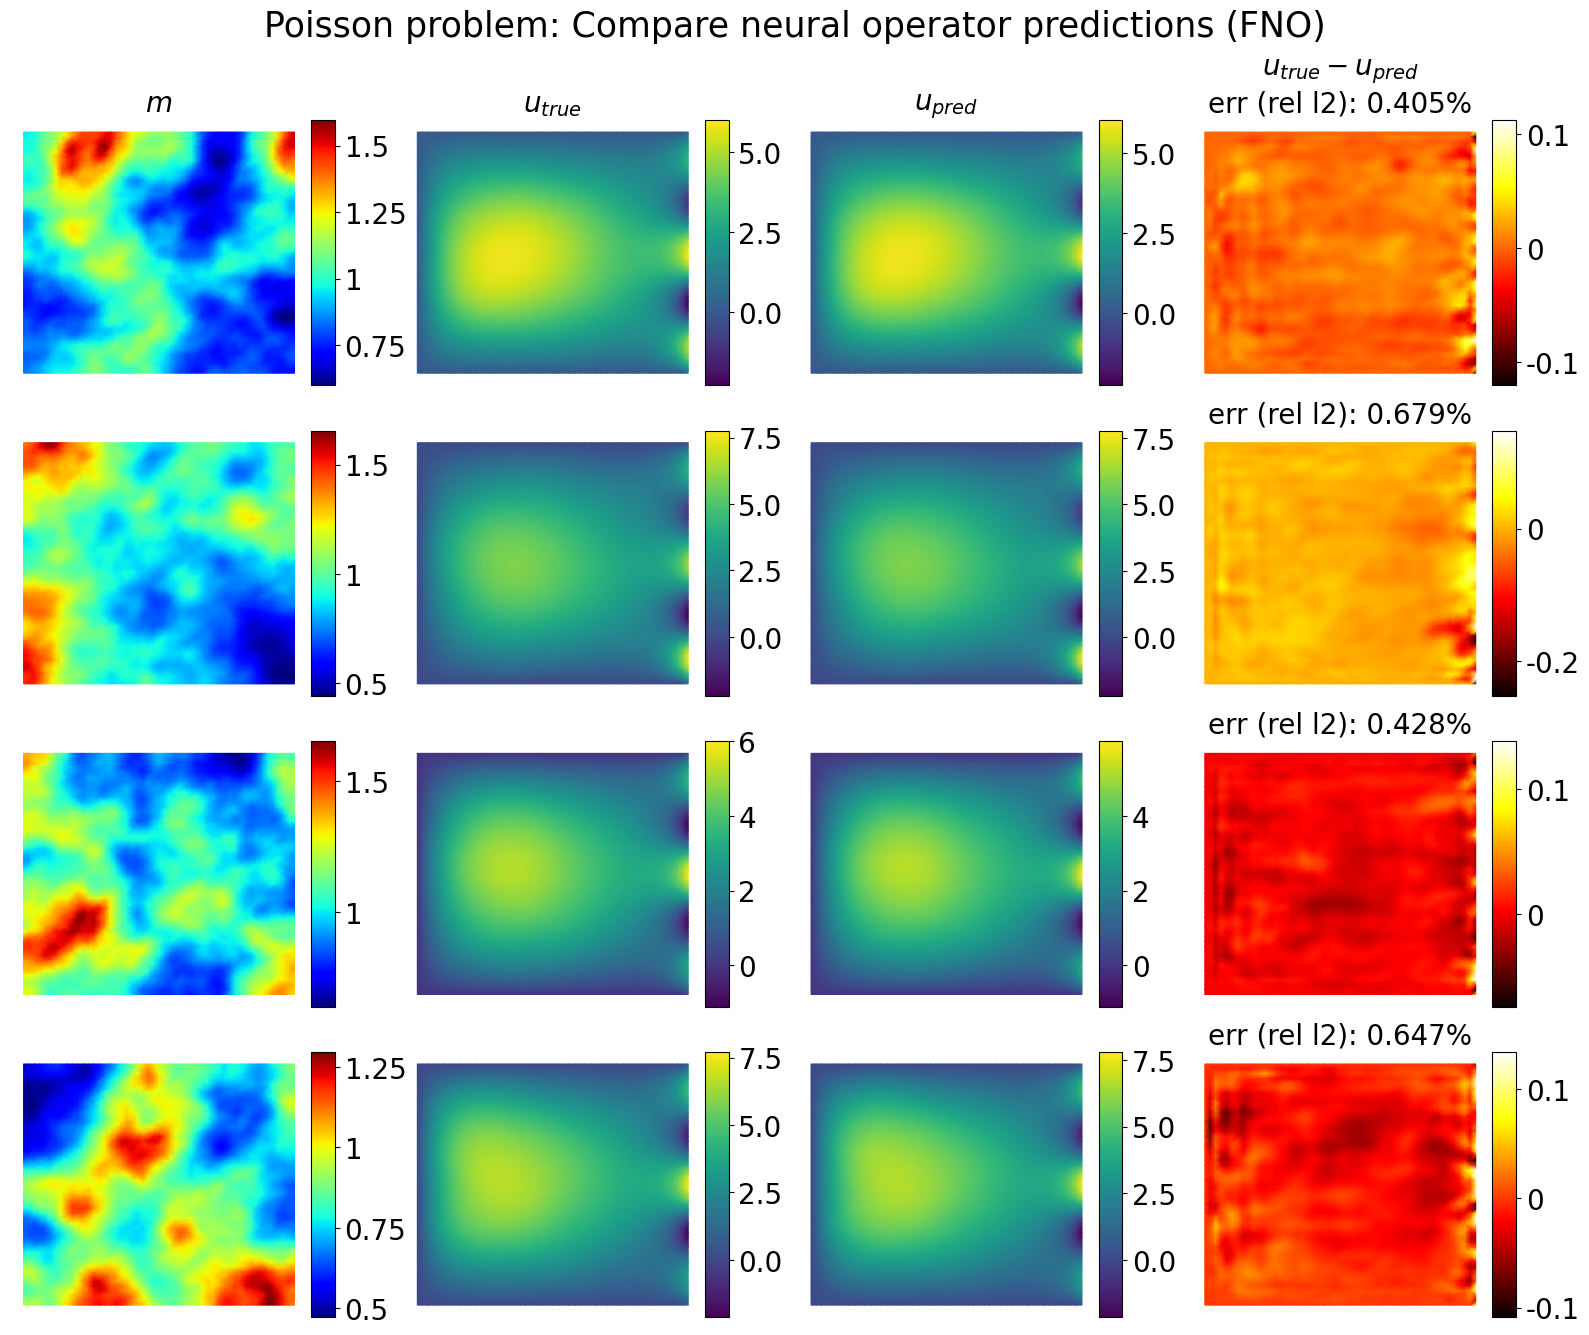

In [15]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

grid_x, grid_y = data.grid_x_test[0], data.grid_y_test[0]

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)[:, :, 0]
        i_truth = data.decoder_Y(i_truth)[:, :, 0]
        i_m_test = data.decoder_X(i_m_test)[:, :, 0]
    else:
        i_pred = i_pred[:, :, 0]
        i_truth = i_truth[:, :, 0]
        i_m_test = i_m_test[:, :, 0]
    if apply_dirichlet_bc_flag:
        i_pred = apply_grid_dirichlet_bc(i_pred, 0.0, data.u_grid_dirichlet_boundary_nodes)
        i_truth = apply_grid_dirichlet_bc(i_truth, 0.0, data.u_grid_dirichlet_boundary_nodes)
        # # verify for i_truth
        # a = i_truth[i, data.u_grid_dirichlet_boundary_nodes[:,0], data.u_grid_dirichlet_boundary_nodes[:,1]]
        # if np.abs(a).max() > 1.0e-9:
        #     print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(a.max()))
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff.flatten()) / np.linalg.norm(i_truth.flatten())
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot_grid(axs[i,j], uvec[j], grid_x, grid_y, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()

## HMC Uncertainty Quantification

In [6]:
hmc_num_samples = 500       # Number of posterior samples to collect
hmc_burn_in = 100           # Burn-in iterations
hmc_leapfrog_steps = 10     # Number of leapfrog steps per iteration
hmc_initial_step_size = 1e-6  # Initial leapfrog step size
hmc_target_accept = 0.65    # Target acceptance rate (0.65-0.80 is optimal for HMC)
hmc_prior_std = 1.0         # Prior std on weights
hmc_noise_std = 0.05        # Observation noise std
hmc_batch_size = None       # Use full batch for HMC (mini-batch can hurt acceptance)

model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Prepare training data for log probability
X_train_tensor = train_data["X_train"].clone().detach().to(device)
Y_train_tensor = train_data["Y_train"].clone().detach().to(device)

# Create log probability function (use smaller batch_size if CUDA OOM)
hmc_log_prob_fn = uq.make_log_prob_fn(
    model, X_train_tensor, Y_train_tensor,
    prior_std=hmc_prior_std,
    noise_std=hmc_noise_std,
    batch_size=hmc_batch_size
)
hmc_flat0 = uq.pack_params(model).to(device)

# Run Adaptive HMC
print("Running HMC sampling...")
hmc_samples, hmc_accept_rate, hmc_final_step_size, hmc_step_size_history = uq.hmc_adaptive(
    hmc_log_prob_fn,
    hmc_flat0.requires_grad_(True),
    target_accept=hmc_target_accept,
    initial_step_size=hmc_initial_step_size,
    leapfrog_steps=hmc_leapfrog_steps,
    num_samples=hmc_num_samples,
    burn_in=hmc_burn_in
)
print(f"HMC completed.")
print(f"  Final acceptance rate: {hmc_accept_rate:.3f}")
print(f"  Final step size: {hmc_final_step_size:.2e}")
print(f"  Number of samples collected: {len(hmc_samples)}")
torch.save(hmc_samples, model_save_path + 'hmc_samples.pt')

Running HMC sampling...
Starting adaptive HMC with target acceptance rate: 65.00%
Adaptation will run for 80 iterations
Iter   50/600: accept rate = 0.620, step_size = 3.22e-07, phase = adapting

>>> Adaptation complete! Final step size: 5.53e-07
>>> Acceptance rate during adaptation: 0.642

Iter  100/600: accept rate = 0.660, step_size = 5.53e-07, phase = burn-in
Iter  150/600: accept rate = 0.720, step_size = 5.53e-07, phase = sampling
Iter  200/600: accept rate = 0.715, step_size = 5.53e-07, phase = sampling
Iter  250/600: accept rate = 0.736, step_size = 5.53e-07, phase = sampling
Iter  300/600: accept rate = 0.753, step_size = 5.53e-07, phase = sampling
Iter  350/600: accept rate = 0.757, step_size = 5.53e-07, phase = sampling
Iter  400/600: accept rate = 0.760, step_size = 5.53e-07, phase = sampling
Iter  450/600: accept rate = 0.773, step_size = 5.53e-07, phase = sampling
Iter  500/600: accept rate = 0.762, step_size = 5.53e-07, phase = sampling
Iter  550/600: accept rate = 0.76

In [6]:
hmc_samples = torch.load(model_save_path + 'hmc_samples.pt')

In [7]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
hmc_metrics, hmc_mean, hmc_std = uq.uqevaluation(test_data, model, data, 'hmc', hmc_samples=hmc_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 0.017709
   MAE:  0.010470
   Mean Relative L2 Error: 0.55%
   Std Relative L2 Error:  0.19%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 98.2% (ideal: 68.3%)
   Coverage within 2σ: 99.7% (ideal: 95.4%)
   Coverage within 3σ: 99.9% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 0.000175
   Mean Total σ:     0.050001
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.693
   → Good! High uncertainty correlates with high error

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 0.0%
   Aleatoric fraction: 100.0%
   → Data noise dominates (model is confident)

6. PROPER SCORING RULES:
   Negative Log-Likelihood: -2.0141
   (Lower is better)



## SGLD Uncertainty Quantification

In [45]:
import importlib
importlib.reload(uq)

<module 'uq' from '/root/experiment/poisson/FNO/../../src/nn/fno/uq.py'>

In [22]:
# SGLD Sampling Parameters (better suited for mini-batch than HMC)
num_samples = 1000      # Number of posterior samples to collect
burn_in = 100          # Burn-in iterations
step_size = 1e-5       # Initial step size for SGLD
step_decay = 0.9995    # Step size decay per iteration
min_step_size = 1e-7   # Minimum step size
prior_std = 1.0        # Prior std on weights
noise_std = 0.05       # Observation noise std
sgld_batch_size = 100  # Mini-batch size for memory efficiency

model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Run SGLD Sampling (works better with mini-batching than HMC)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Prepare training data for log probability
X_train_tensor = train_data["X_train"].clone().to(device)
Y_train_tensor = train_data["Y_train"].clone().to(device)

# Create log probability function with mini-batch for memory efficiency
log_prob_fn = uq.make_log_prob_fn(
    model, X_train_tensor, Y_train_tensor,
    prior_std=prior_std,
    noise_std=noise_std,
    batch_size=sgld_batch_size,
    reduce_output_mean=True
)
flat0 = uq.pack_params(model).detach().requires_grad_(True)

# Run SGLD (Stochastic Gradient Langevin Dynamics)
# Note: SGLD is specifically designed for mini-batch settings and doesn't suffer
# from the acceptance rate issues that HMC has with stochastic gradients
print("Running SGLD sampling...")
sgld_samples, final_step_size = uq.sgld(
    log_prob_fn,
    flat0,
    step_size=step_size,
    num_samples=num_samples,
    burn_in=burn_in,
    step_decay=step_decay,
    min_step_size=min_step_size
)
sgld_samples = torch.stack(sgld_samples)
print(f"SGLD completed. Final step size: {final_step_size:.2e}")
print(f"Number of samples collected: {len(sgld_samples)}")

Running SGLD sampling...
Starting SGLD sampling...
  Burn-in: 100, Samples: 1000
  Initial step size: 1.00e-05
Iter  100/1100: step_size = 9.51e-06, phase = burn-in
Iter  200/1100: step_size = 9.05e-06, phase = sampling
Iter  300/1100: step_size = 8.61e-06, phase = sampling
Iter  400/1100: step_size = 8.19e-06, phase = sampling
Iter  500/1100: step_size = 7.79e-06, phase = sampling
Iter  600/1100: step_size = 7.41e-06, phase = sampling
Iter  700/1100: step_size = 7.05e-06, phase = sampling
Iter  800/1100: step_size = 6.70e-06, phase = sampling
Iter  900/1100: step_size = 6.38e-06, phase = sampling
Iter 1000/1100: step_size = 6.06e-06, phase = sampling
Iter 1100/1100: step_size = 5.77e-06, phase = sampling
SGLD completed. Collected 1000 samples.
SGLD completed. Final step size: 5.77e-06
Number of samples collected: 1000


In [23]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Evaluate SGLD
sgld_metrics, sgld_mean, sgld_std = uq.uqevaluation(test_data, model, data, 'sgld', sgld_samples=sgld_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 0.693855
   MAE:  0.499235
   Mean Relative L2 Error: 23.08%
   Std Relative L2 Error:  2.96%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 58.1% (ideal: 68.3%)
   Coverage within 2σ: 86.2% (ideal: 95.4%)
   Coverage within 3σ: 96.7% (ideal: 99.7%)
   Status: UNDER-CONFIDENT (uncertainties too large)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 0.528360
   Mean Total σ:     0.534669
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.213
   → Moderate correlation

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 91.1%
   Aleatoric fraction: 8.9%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 0.8953
   (Lower is better)



## MC Dropout 


In [46]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Run MC Dropout Sampling
num_samples=100
uq.inject_dropout(model)
torch.nn.Module.train(model)
# Enable dropout for both Dropout and Dropout2d layers
for module in model.modules():
    if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
        torch.nn.Module.train(module)
# MC Dropout Comprehensive Evaluation
mcd_metrics, mcd_mean, mcd_std = uq.uqevaluation(test_data, model, data, 'mcd')

Running MC Dropout sampling...
MC Dropout predictions shape: (100, 1000, 51, 51, 1)

1. PREDICTION ACCURACY:
   RMSE: 0.846997
   MAE:  0.635059
   Mean Relative L2 Error: 27.97%
   Std Relative L2 Error:  6.34%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 100.0% (ideal: 68.3%)
   Coverage within 2σ: 100.0% (ideal: 95.4%)
   Coverage within 3σ: 100.0% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 3.445858
   Mean Total σ:     3.449159
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.429
   → Moderate correlation

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 94.2%
   Aleatoric fraction: 5.8%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 1.8631
   (Lower is better)



## Laplace Approximation

In [47]:
prior_precision = 1.0
prior_std = 1.0   
noise_std = 0.05        
epoch_la = 200      

# Compute Diagonal Hessian for Laplace Approximation
print("Computing diagonal Hessian...")

model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Use a subset of training data for Hessian computation (for efficiency)
n_hessian = min(100, num_train)
X_hessian = X_train_tensor[:n_hessian]
Y_hessian = Y_train_tensor[:n_hessian]

# Compute diagonal Hessian (note: function signature includes noise_std, prior_std, device)
diag_hessian = uq.compute_diagonal_hessian(
    model, X_hessian, Y_hessian,
    noise_std=noise_std,
    prior_std=prior_std,
    device=device,
    batch_size=20,
    sample_points_per_batch=50
)

# Compute posterior precision and variance (diagonal approximation)
# posterior_precision = prior_precision + data_precision * Hessian
# Note: The prior term is already included in compute_diagonal_hessian
posterior_precision = diag_hessian  # Already includes prior term
posterior_variance = 1.0 / (posterior_precision + 1e-10)

print(f"Number of parameters: {len(diag_hessian)}")
print(f"Mean posterior variance: {posterior_variance.mean().item():.6e}")
print(f"Max posterior variance: {posterior_variance.max().item():.6e}")
# Sample from Laplace Posterior and Make Predictions
print("Sampling from Laplace posterior...")

# Get MAP parameters (this is the flattened real-valued parameter vector)
map_params = uq.pack_params(model).to(device)
# Sample from Gaussian posterior
posterior_std = torch.sqrt(posterior_variance)
la_samples=[]
for i in range(epoch_la):
    noise = torch.randn_like(map_params) * posterior_std
    sampled_params = map_params + noise
    la_samples.append(sampled_params)
la_samples = torch.stack(la_samples) 


Computing diagonal Hessian...
  Processed 100/100 samples
Number of parameters: 308561
Mean posterior variance: 8.905249e-02
Max posterior variance: 1.000000e+00
Sampling from Laplace posterior...


In [48]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
la_metrics, la_mean, la_std = uq.uqevaluation(test_data, model, data, 'la', la_samples=la_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 0.351463
   MAE:  0.248619
   Mean Relative L2 Error: 11.83%
   Std Relative L2 Error:  1.63%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 100.0% (ideal: 68.3%)
   Coverage within 2σ: 100.0% (ideal: 95.4%)
   Coverage within 3σ: 100.0% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 4.809087
   Mean Total σ:     4.812295
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.062
   → Weak correlation - uncertainty may not be informative

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 94.2%
   Aleatoric fraction: 5.8%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 2.1468
   (Lower is better)



## UQ Methods Comparison


Metric                             HMC         SGLD   MC Dropout      Laplace      Ideal
----------------------------------------------------------------------------------------------------
RMSE                          0.017709     0.693855     0.846997     0.351463      Lower
MAE                           0.010470     0.499235     0.635059     0.248619      Lower
Mean Rel. L2 Error (%)            0.55        23.08        27.97        11.83      Lower
Coverage 1σ (%)                   98.2         58.1        100.0        100.0       68.3
Coverage 2σ (%)                   99.7         86.2        100.0        100.0       95.4
Coverage 3σ (%)                   99.9         96.7        100.0        100.0       99.7
Mean Epistemic σ              0.000175     0.528360     3.445858     4.809087          -
Mean Total σ                  0.050001     0.534669     3.449159     4.812295          -
Epistemic Fraction (%)             0.0         91.1         94.2         94.2          -
Uncertai

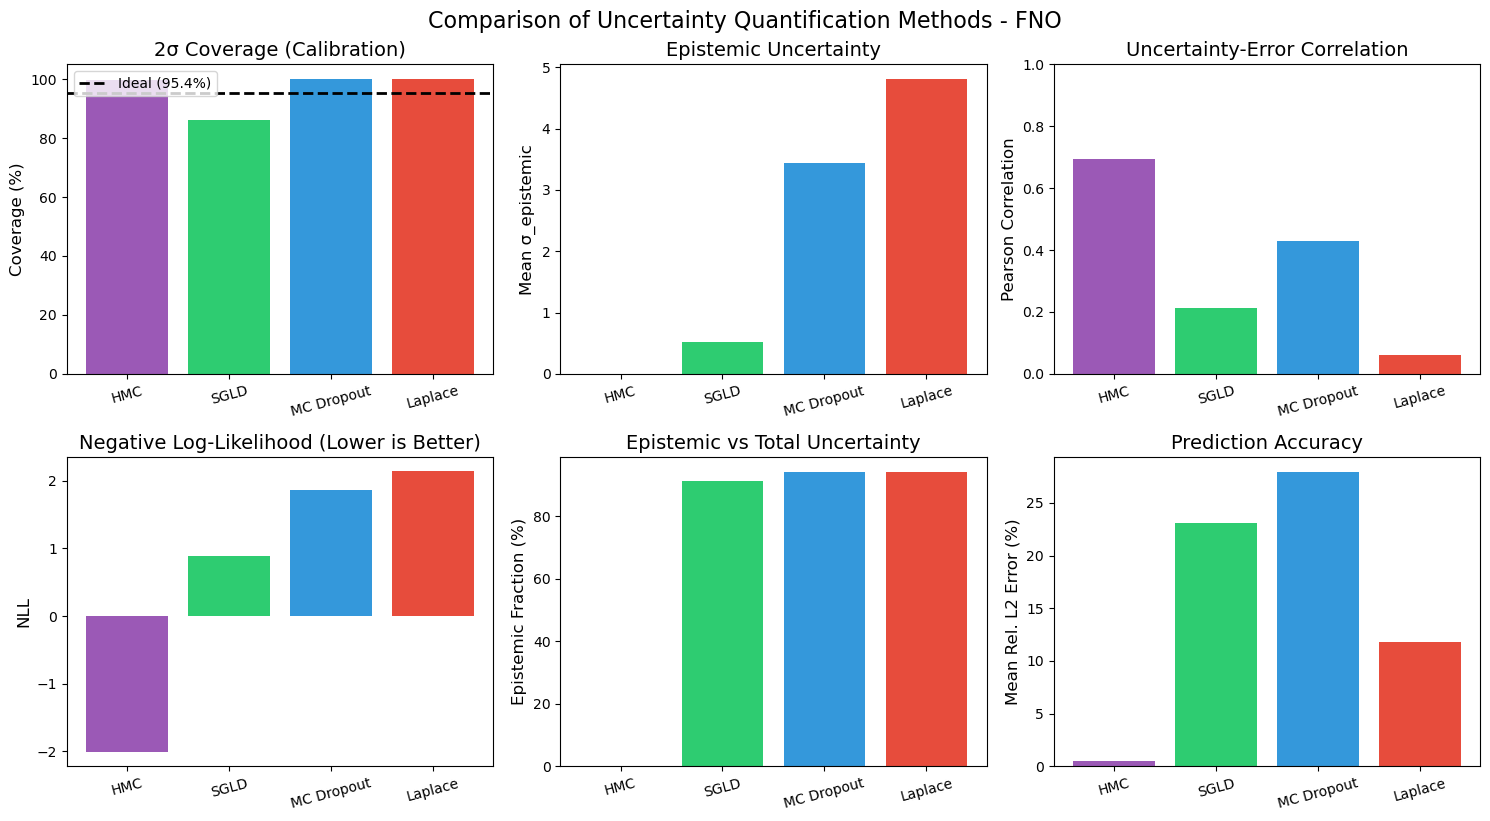

In [49]:
uq.comparison_plotting(hmc_metrics, sgld_metrics, mcd_metrics, la_metrics)

## Behaviour on OOD data

In [28]:
datas = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_ood.npz', 3, 600, num_Y_components, coarsen_grid_factor)
data_ood = {'X_train': datas.X_test, 'Y_train': datas.Y_test}

In [29]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
hmc_metrics_1, hmc_mean_1, hmc_std_1 = uq.uqevaluation(data_ood, model, data, 'hmc', hmc_samples=hmc_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 10.164964
   MAE:  5.811911
   Mean Relative L2 Error: 163.14%
   Std Relative L2 Error:  111.63%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 10.6% (ideal: 68.3%)
   Coverage within 2σ: 14.2% (ideal: 95.4%)
   Coverage within 3σ: 17.1% (ideal: 99.7%)
   Status: UNDER-CONFIDENT (uncertainties too large)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 0.007064
   Mean Total σ:     0.051395
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.945
   → Good! High uncertainty correlates with high error

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 4.1%
   Aleatoric fraction: 95.9%
   → Data noise dominates (model is confident)

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 13958.1645
   (Lower is better)



In [30]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
sgld_metrics_1, sgld_mean_1, sgld_std_1 = uq.uqevaluation(data_ood, model, data, 'sgld', sgld_samples=sgld_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 7.247104
   MAE:  3.448172
   Mean Relative L2 Error: 113.69%
   Std Relative L2 Error:  75.39%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 55.8% (ideal: 68.3%)
   Coverage within 2σ: 70.6% (ideal: 95.4%)
   Coverage within 3σ: 79.9% (ideal: 99.7%)
   Status: UNDER-CONFIDENT (uncertainties too large)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 2.721408
   Mean Total σ:     2.725723
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.057
   → Weak correlation - uncertainty may not be informative

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 93.3%
   Aleatoric fraction: 6.7%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 4.8484
   (Lower is better)



In [50]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
uq.inject_dropout(model)
torch.nn.Module.train(model)
# Enable dropout for both Dropout and Dropout2d layers
for module in model.modules():
    if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
        torch.nn.Module.train(module)
# MC Dropout Comprehensive Evaluation
mcd_metrics_1, mcd_mean_1, mcd_std_1 = uq.uqevaluation(data_ood, model, data, 'mcd')

Running MC Dropout sampling...
MC Dropout predictions shape: (100, 600, 51, 51, 1)

1. PREDICTION ACCURACY:
   RMSE: 10.300255
   MAE:  5.817941
   Mean Relative L2 Error: 174.37%
   Std Relative L2 Error:  106.60%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 99.9% (ideal: 68.3%)
   Coverage within 2σ: 100.0% (ideal: 95.4%)
   Coverage within 3σ: 100.0% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 30.605910
   Mean Total σ:     30.608940
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.330
   → Moderate correlation

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 94.3%
   Aleatoric fraction: 5.7%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 3.3880
   (Lower is better)



In [51]:
model = torch.load(model_save_file, weights_only=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
la_metrics_1, la_mean_1, la_std_1  = uq.uqevaluation(data_ood, model, data, 'la', la_samples=la_samples.clone())


1. PREDICTION ACCURACY:
   RMSE: 10.162334
   MAE:  5.669742
   Mean Relative L2 Error: 161.75%
   Std Relative L2 Error:  109.98%

2. CALIBRATION (Coverage Analysis):
   Coverage within 1σ: 94.1% (ideal: 68.3%)
   Coverage within 2σ: 99.9% (ideal: 95.4%)
   Coverage within 3σ: 100.0% (ideal: 99.7%)
   Status: OVER-CONFIDENT (uncertainties too small)

3. SHARPNESS (Uncertainty Magnitude):
   Mean Epistemic σ: 20.824308
   Mean Total σ:     20.827328
   Mean Aleatoric σ: 0.050000 (fixed)

4. UNCERTAINTY-ERROR CORRELATION:
   Pearson correlation: 0.355
   → Moderate correlation

5. UNCERTAINTY DECOMPOSITION:
   Epistemic fraction: 94.3%
   Aleatoric fraction: 5.7%
   → Model uncertainty dominates

6. PROPER SCORING RULES:
   Negative Log-Likelihood: 3.3126
   (Lower is better)




Metric                             HMC         SGLD   MC Dropout      Laplace      Ideal
----------------------------------------------------------------------------------------------------
RMSE                         10.164964     7.247104    10.300255    10.162334      Lower
MAE                           5.811911     3.448172     5.817941     5.669742      Lower
Mean Rel. L2 Error (%)          163.14       113.69       174.37       161.75      Lower
Coverage 1σ (%)                   10.6         55.8         99.9         94.1       68.3
Coverage 2σ (%)                   14.2         70.6        100.0         99.9       95.4
Coverage 3σ (%)                   17.1         79.9        100.0        100.0       99.7
Mean Epistemic σ              0.007064     2.721408    30.605910    20.824308          -
Mean Total σ                  0.051395     2.725723    30.608940    20.827328          -
Epistemic Fraction (%)             4.1         93.3         94.3         94.3          -
Uncertai

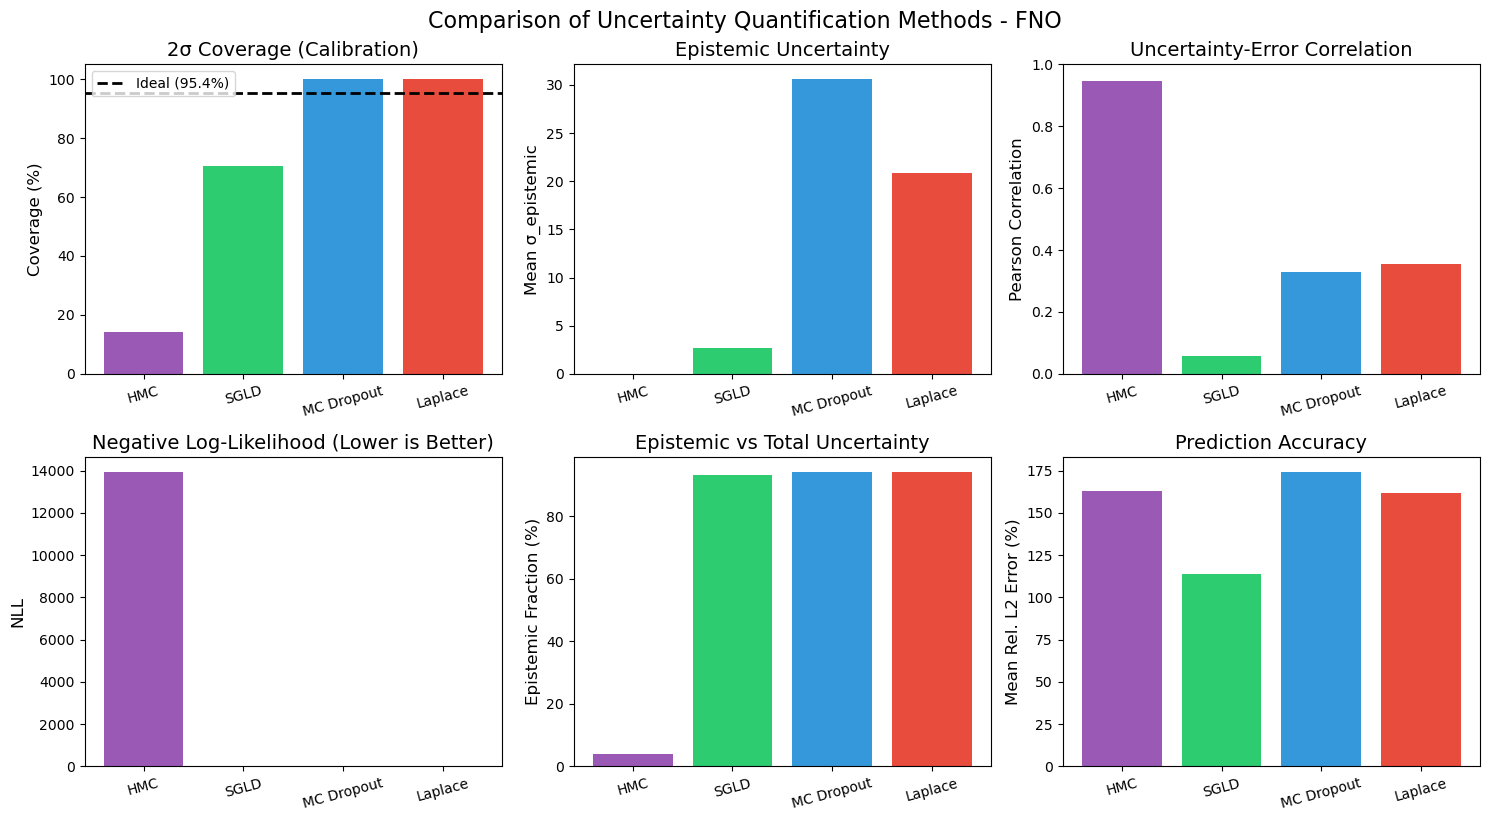

In [52]:
uq.comparison_plotting(hmc_metrics_1, sgld_metrics_1, mcd_metrics_1, la_metrics_1)

## ood data detection

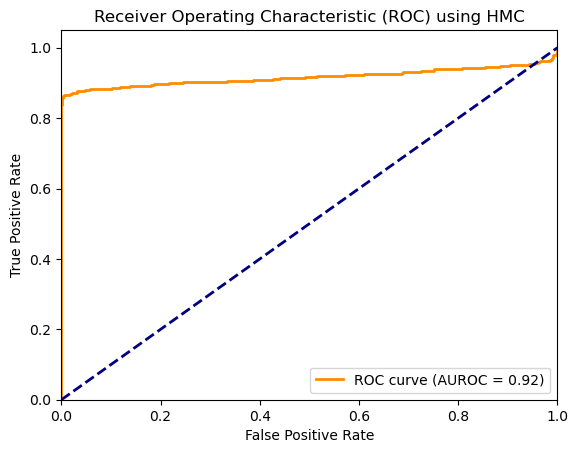

AUROC for OOD detection: 0.9165733333333334


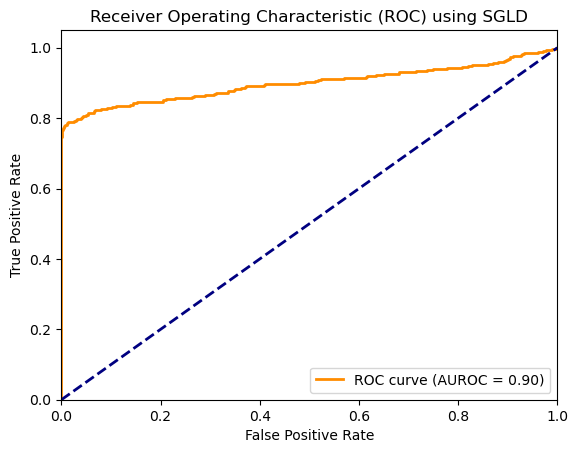

AUROC for OOD detection: 0.8989733333333333


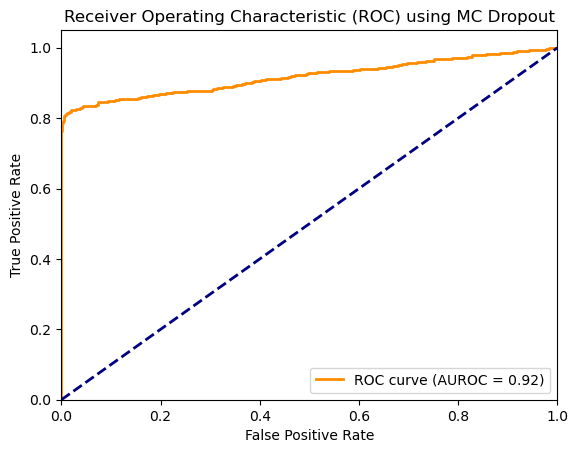

AUROC for OOD detection: 0.9181366666666667


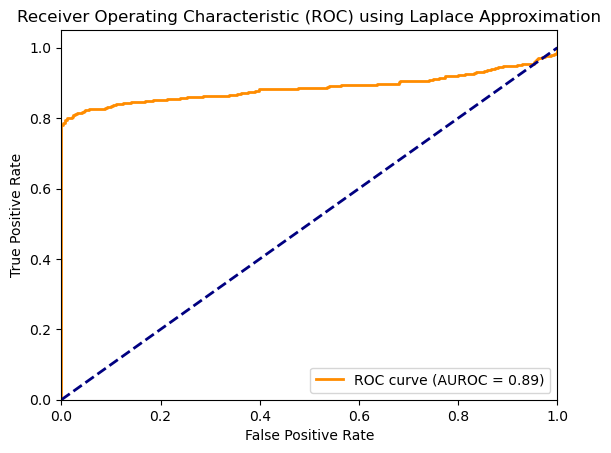

AUROC for OOD detection: 0.8862966666666666


In [53]:
hmc_ood_eval = np.concatenate((hmc_std.mean(axis=1),hmc_std_1.mean(axis=1)), axis=0)  # epistemic + aleatoric
hmc_ood_eval = hmc_ood_eval/np.max(hmc_ood_eval)
sgld_ood_eval = np.concatenate((sgld_std.mean(axis=1),sgld_std_1.mean(axis=1)), axis=0)
sgld_ood_eval = sgld_ood_eval/np.max(sgld_ood_eval)
mcd_ood_eval = np.concatenate((mcd_std.mean(axis=1),mcd_std_1.mean(axis=1)), axis=0)
mcd_ood_eval = mcd_ood_eval/np.max(mcd_ood_eval)
la_ood_eval = np.concatenate((la_std.mean(axis=1),la_std_1.mean(axis=1)), axis=0)
la_ood_eval = la_ood_eval/np.max(la_ood_eval)
oods = np.concatenate((np.zeros(hmc_std.shape[0]), np.ones(hmc_std_1.shape[0])), axis=0)  # 0 for ID, 1 for OOD
#Examine OOD data:
# Step 1: Generate uncertainty scores: ood_eval
# Step 2: Create true labels for AUROC (1 for OOD, 0 for ID): oods
# Step 3: Calculate AUROC
for ood, uqmethod in zip([hmc_ood_eval, sgld_ood_eval, mcd_ood_eval, la_ood_eval], ['HMC', 'SGLD', 'MC Dropout', 'Laplace Approximation']):
    auroc = roc_auc_score(oods, ood)
    fpr, tpr, _ = roc_curve(oods, ood)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUROC = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) using {uqmethod}')
    plt.legend(loc='lower right')
    plt.show()
    print(f"AUROC for OOD detection: {auroc}")
